<h1 style='font-weight: bold; text-align: center; background: green; color: white'>ASKING MEANINGFUL QUESTIONS</h1>

<h2 style='font-weight: bold'>1. IMPORT LIBRARIES</h2>

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multicomp import pairwise_tukeyhsd

<h2 style='font-weight: bold'>2. READ RAW DATA FROM CSV FILE</h2>

In [36]:
df = pd.DataFrame()
df = pd.read_csv('players_transformed.csv')

# drop unecessary column
df = df.drop(df.columns[0], axis=1)

# test output
display(df.head())

# size of the data
print("Size of data: ", df.shape)

,name,age,nationality,club,height,weight,foot,total_matches,total_goals,total_assists,...,shot_accuracy,pass_completion_rate,cross_completion_rate,dribble_success_rate,tackles,interception,market_value,titles,injuries,general_position
0,Ardian Ismajli,28,Albania,Empoli,185,76,Right,231,5,17.0,...,0.00,83.88,21.43,0.00,9,21,5.0,0,3,Defender
1,Berat Djimsiti,31,Albania,Atalanta,190,83,Right,474,15,9.0,...,0.00,88.00,0.00,100.00,26,19,10.0,2,5,Defender
2,Ivan Balliu,32,Albania,Rayo Vallecano,172,63,Right,423,3,9.0,...,46.15,76.73,0.00,66.67,10,6,2.0,2,19,Defender
3,Kristjan Asllani,22,Albania,Inter Milan,175,63,Right,110,6,5.0,...,50.00,90.57,50.00,0.00,4,0,18.0,6,1,Midfielder
4,Marash Kumbulla,24,Albania,RCD Espanyol,191,78,Right,133,6,6.0,...,50.00,86.00,66.67,33.33,12,11,4.5,1,3,Defender


Size of data:  (1635, 24)


<h2 style='font-weight: bold'>QUESTION 1</h2>

<p style='font-weight: bold; font-size: 30px' >Can we identify young players (e.g., under 23) who have high efficiency and are undervalued in the market compared to their peers?<p>



### Purpose
To identify promising young players who deliver exceptional performance relative to their market value, making them attractive targets for clubs seeking high-value talent on a budget.

### Relevant attributes
- `age`
- `market_value`
- `shot_accuracy`
- `total_goals`
- `total_assists`
- `pass_completion_rate`
- `dribble_success_rate`
- `tackles`
- `interception`

### 1. Filter Players Under 23 and Define Efficiency Metrics

Efficiency is calculated by adding the products of the relevant statistics and their corresponding weight. 1 is chosen as the total weight for ease of comparision.

In [37]:
young_players = df[df['age'] < 23].copy()

young_players['efficiency'] = (
    young_players['shot_accuracy'] * 0.25 +
    young_players['total_goals'] * 0.2 +
    young_players['total_assists'] * 0.2 +
    young_players['pass_completion_rate'] * 0.15 +
    young_players['dribble_success_rate'] * 0.1 +
    young_players['tackles'] * 0.05 +
    young_players['interception'] * 0.05
)

### 2. Compare Market Value

Identify players who are "undervalued" by comparing their efficiency to their market value. A player is "undervalued" when they are priced lower than the average market value of peers who has similar efficiency value (within 10%)

In [38]:
undervalued_players = []

for index, player in young_players.iterrows():
    efficiency = player['efficiency']
    
    # Define the efficiency range (10%)
    lower_bound = efficiency * 0.9
    upper_bound = efficiency * 1.1
    
    # Find peers within this range
    peers = young_players[(young_players['efficiency'] >= lower_bound) & 
                          (young_players['efficiency'] <= upper_bound) &
                          (young_players.index != index)]  # Exclude the player themselves
    
    # Calculate the average market value of peers
    if not peers.empty:
        avg_peer_value = peers['market_value'].mean()
        
        # Check if the player is undervalued
        if player['market_value'] < avg_peer_value:
            undervalued_players.append({
                'name': player['name'],
                'age': player['age'],
                'efficiency': efficiency,
                'market_value': player['market_value'],
                'avg_peer_value': avg_peer_value
            })

# Convert the results into a DataFrame
undervalued_df = pd.DataFrame(undervalued_players)

# Rank Undervalued Players
undervalued_df['value_gap'] = undervalued_df['avg_peer_value'] - undervalued_df['market_value']
undervalued_df = undervalued_df.sort_values(by='value_gap', ascending=False)

display(undervalued_df)

,name,age,efficiency,market_value,avg_peer_value,value_gap
18,Mahamadou Nagida,19,55.0975,0.5,21.000000,20.500000
62,Mamadou Diakhon,19,46.2690,0.7,15.254545,14.554545
14,Stanis Idumbo Muzambo,19,46.5670,0.8,14.880645,14.080645
125,Daniele Ghilardi,21,45.3995,1.6,15.097222,13.497222
80,Tom Louchet,21,43.5390,3.0,14.987755,11.987755
...,...,...,...,...,...,...
36,Andy Diouf,21,25.9690,9.0,9.218269,0.218269
0,Zito Luvumbo,22,28.8380,7.5,7.641500,0.141500
11,Matias Fernandez Pardo,19,31.5705,8.0,8.056081,0.056081
156,Keyliane Hikram Abdallah,18,26.5875,8.0,8.020561,0.020561


### Conclusion

It is possible to determine young players who are undervalued compared to their peers by calculating their efficiency based on the predetermined metric and compare the market values of players with similar efficiency.

<h2 style='font-weight: bold'>QUESTION 2</h2>

<p style='font-weight: bold; font-size: 30px' >Do offense or defense statistics have a higher impact on a player's market value? <p>

### Purpose
To help teams, scouts, and analysts understand how the market perceives different player roles and skill sets, which can influence decisions on recruitment, training focus, and contract negotiations.

#### 1. Define Relevant Attributes
We focus on attributes that represent offensive and defensive capabilities, as well as the player's market value:
- Offensive stats: `total_goals`, `total_assists`, `pass_completion_rate`, `dribble_success_rate` - represent a player's contribution to scoring, creating opportunities, and maintaining possession.
- Defensive stats: `tackles`, `interception`, `total_yellow`, `total_red` - measure a player's ability to disrupt opponents' plays and their discipline (via cards)

In [39]:
offensive_stats = ['total_goals', 'total_assists', 'pass_completion_rate', 'dribble_success_rate']
defensive_stats = ['tackles', 'interception', 'total_yellow', 'total_red']
market_value = 'market_value'

# Select relevant data
selected_columns = offensive_stats + defensive_stats + [market_value]
q2_data = df[selected_columns]
q2_data

,total_goals,total_assists,pass_completion_rate,dribble_success_rate,tackles,interception,total_yellow,total_red,market_value
0,5,17.0,83.88,0.00,9,21,55,2,5.0
1,15,9.0,88.00,100.00,26,19,79,1,10.0
2,3,9.0,76.73,66.67,10,6,91,2,2.0
3,6,5.0,90.57,0.00,4,0,9,0,18.0
4,6,6.0,86.00,33.33,12,11,32,2,4.5
...,...,...,...,...,...,...,...,...,...
1630,61,40.0,74.70,33.33,5,3,47,2,2.0
1631,3,0.0,33.33,0.00,0,0,4,0,7.0
1632,5,10.0,81.98,42.86,6,3,11,0,5.0
1633,23,10.0,76.80,42.86,18,9,45,2,10.0


#### 2. Correlation Analysis
Why correlation?
- Correlation quantifies the linear relationship between two variables
- Higher correlation indicates stronger alignment between a stat and `market_value`, helping us identify which stats matter more.
1. We compute the correlation matrix for the selected attributes
2. Extract the correlation values of offensive and defensive stats with `market_value`.
3. Compute average correlations for offensive and defensive stats.

In [40]:
correlation_matrix = q2_data.corr()

# Extract the correlation values with `market_value`
offensive_columns = correlation_matrix.loc[offensive_stats, market_value]
defensive_columns = correlation_matrix.loc[defensive_stats, market_value]

# Calculate average correlations
average_offensive_corr = offensive_columns.mean()
average_defensive_corr = defensive_columns.mean()

#### 3. Summary statistics
Why summary statistics?
- To understand the overall trends and variability of offensive and defensive stats.
- Attributes like mean, std, and range reveal:
  - How consistent the stats are.
  - Whether certain stats (e.g., goals or tackles) dominate the dataset.
1. Compute mean, standard deviation, min, max, and other relevant statistics for offensive and defensive attributes.
2. Compare offensive and defensive metrics to understand which group of stats shows greater variability or consistency

In [41]:
offensive_summary = q2_data[offensive_stats].describe()
defensive_summary = q2_data[defensive_stats].describe()

display(offensive_summary)
display(defensive_summary)

,total_goals,total_assists,pass_completion_rate,dribble_success_rate
count,1635.000000,1635.000000,1635.000000,1635.000000
mean,20.151070,15.701529,80.450391,38.945969
std,22.080936,11.773836,10.025872,30.601433
min,0.000000,0.000000,0.000000,0.000000
25%,4.000000,7.000000,76.795000,0.000000
50%,12.000000,14.000000,81.980000,42.860000
75%,29.000000,23.000000,86.445000,54.550000
max,100.000000,69.000000,100.000000,100.000000


,tackles,interception,total_yellow,total_red
count,1635.000000,1635.000000,1635.000000,1635.000000
mean,8.098471,4.044037,32.273394,1.553517
std,7.421608,4.292177,26.910919,1.880140
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,12.000000,0.000000
50%,6.000000,3.000000,26.000000,1.000000
75%,12.000000,6.000000,47.000000,2.000000
max,39.000000,24.000000,161.000000,14.000000


#### 4. Interpretation of Results
After computing correlations and summary statistics:
1. Correlations reveal which group has higher average alignment with market value.
2. Summary statistics help contextualize the influence (e.g., whether high goals scored are rarer, boosting value disproportionately).

In [42]:
print("=== Correlations with Market Value ===")
print("Offensive Stats Correlations:")
display(offensive_columns)
print("\nDefensive Stats Correlations:")
display(defensive_columns)
print("\nAverage Offensive Correlation:", average_offensive_corr)
print("Average Defensive Correlation:", average_defensive_corr)

print("\n=== Summary Statistics ===")
print("Offensive Stats Summary:")
display(offensive_summary)
print("\nDefensive Stats Summary:")
display(defensive_summary)

=== Correlations with Market Value ===
Offensive Stats Correlations:


total_goals             0.162322
total_assists           0.210996
pass_completion_rate    0.201403
dribble_success_rate    0.091309
Name: market_value, dtype: float64


Defensive Stats Correlations:


tackles         0.115006
interception    0.076152
total_yellow    0.014667
total_red      -0.009276
Name: market_value, dtype: float64


Average Offensive Correlation: 0.16650766966767022
Average Defensive Correlation: 0.04913703462824452

=== Summary Statistics ===
Offensive Stats Summary:


,total_goals,total_assists,pass_completion_rate,dribble_success_rate
count,1635.000000,1635.000000,1635.000000,1635.000000
mean,20.151070,15.701529,80.450391,38.945969
std,22.080936,11.773836,10.025872,30.601433
min,0.000000,0.000000,0.000000,0.000000
25%,4.000000,7.000000,76.795000,0.000000
50%,12.000000,14.000000,81.980000,42.860000
75%,29.000000,23.000000,86.445000,54.550000
max,100.000000,69.000000,100.000000,100.000000



Defensive Stats Summary:


,tackles,interception,total_yellow,total_red
count,1635.000000,1635.000000,1635.000000,1635.000000
mean,8.098471,4.044037,32.273394,1.553517
std,7.421608,4.292177,26.910919,1.880140
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,12.000000,0.000000
50%,6.000000,3.000000,26.000000,1.000000
75%,12.000000,6.000000,47.000000,2.000000
max,39.000000,24.000000,161.000000,14.000000


#### 5. Key observations
Offensive Stats correlate more strongly:
- The average offensive correlation (0.1665) is four times more than the defensive correlation (0.0491), suggesting that offensive stats have a stronger relationship with market value.

Weak correlations overall:
- Even the strongest correlations, such as `pass_completion_rate` (0.20) and `total_assists` (0.21), are in the weak range, indicating that these stats alone are not dominant predictions of market value.
- Defensive stats, particularly `total_yellow` and `total_red`, show almost no relationship with market value 

#### 6. Implications
- Offensive performance (e.g., creating and scoring goals) seems to have a slightly stronger impact on market value than defensive capabilities, aligning with the market's bias toward players who directly contribute to goal-scoring.
- The weak correlations overall suggest that market value depends on additional factors beyond offensive and defensive statistics, such as:
  - Age, physical attributes, or popularity.
  - Positional roles (e.g., forwards may inherently have higher values).
  - Team success or league competitiveness.

#### 7. Conclusion
While offensive stats have a stronger impact than defensive stats, neither group has a particularly strong influence on market value. Teams and analysts should consider a broader range of metrics, including off-field factors, when evaluating player market value.

<h2 style='font-weight: bold'>QUESTION 3</h2>

<p style='font-weight: bold; font-size: 30px' >How do injuries affectt a player's long-term performance and market value<p>

### Purpose

This question helps assess the impact of injury history on both performance and value, which could be useful for clubs in managing risk when signing players.

### Relevant attributes

- `injuries`
- `total_matches`
- `total_goals`
- `total_assists`
- `shot_accuracy`
- `pass_completion_rate`
- `dribble_success_rate`
- `total_yellow`
- `total_red`
- `market_value`


In [43]:
# filter relevant columns
relevant_columns = ['injuries', 'total_matches', 'total_goals', 'total_assists', 'shot_accuracy', 'pass_completion_rate', 'dribble_success_rate',
                    'total_yellow', 'total_red', 'market_value']
df_subset = df[relevant_columns].copy()

### 1. Group Players by Injury Counts

Create categories for players based on their injury history, such as:
- Low Injury (< 3 injuries)
- Moderate Injury (3–6 injuries)
- High Injury (> 6 injuries)

In [44]:
df_subset['injury_category'] = pd.cut(df_subset['injuries'], 
                                      bins=[-1, 3, 6, float('inf')], 
                                      labels=['Low', 'Moderate', 'High'])
display(df_subset.head())

,injuries,total_matches,total_goals,total_assists,shot_accuracy,pass_completion_rate,dribble_success_rate,total_yellow,total_red,market_value,injury_category
0,3,231,5,17.0,0.00,83.88,0.00,55,2,5.0,Low
1,5,474,15,9.0,0.00,88.00,100.00,79,1,10.0,Moderate
2,19,423,3,9.0,46.15,76.73,66.67,91,2,2.0,High
3,1,110,6,5.0,50.00,90.57,0.00,9,0,18.0,Low
4,3,133,6,6.0,50.00,86.00,33.33,32,2,4.5,Low


### 2. Analyze Impact on Performance

**a. Compare Averages:**

Calculate average performance metrics (e.g., goals, assists, etc.) across injury categories

In [45]:
performance_by_injury = df_subset.groupby('injury_category', observed=False).mean()
display(performance_by_injury)

,injuries,total_matches,total_goals,total_assists,shot_accuracy,pass_completion_rate,dribble_success_rate,total_yellow,total_red,market_value
injury_category,,,,,,,,,,
Low,0.985528,138.033285,14.541245,11.390738,43.530825,79.131042,37.741795,17.678726,0.787265,6.982091
Moderate,4.846457,212.011811,20.314961,16.523622,43.697244,79.524488,34.689724,29.992126,1.342520,10.085433
High,15.350725,290.604348,25.708696,19.715942,42.840174,82.112493,41.718681,47.728986,2.398551,11.282681


**Statistical Tests**

Use tests to check if the differences in performance are significant:
- Analysis of Variance: To compare means across multiple groups.
- Correlation: To see how injuries correlate with relevant attributes.

In [46]:
for column in ['total_matches', 'total_goals', 'total_assists', 'shot_accuracy', 'pass_completion_rate', 'dribble_success_rate', 'total_yellow', 'total_red', 'market_value']:
    low_injury = df_subset[df_subset['injury_category'] == 'Low'][column]
    moderate_injury = df_subset[df_subset['injury_category'] == 'Moderate'][column]
    high_injury = df_subset[df_subset['injury_category'] == 'High'][column]

    f_stat, p_value = stats.f_oneway(low_injury, moderate_injury, high_injury)
    print(f"ANOVA Test: F-Statistic = {f_stat}, P-Value = {p_value}")
    
    confidence_level = 0.95
    if p_value < 1 - confidence_level:
        print(f"Reject the null hypothesis for {column}")
    else:
        print(f"Fail to reject the null hypothesis for {column}")
    print()


ANOVA Test: F-Statistic = 372.9227032007741, P-Value = 4.1097501435624567e-134
Reject the null hypothesis for total_matches

ANOVA Test: F-Statistic = 46.62945166837829, P-Value = 2.0256095319617927e-20
Reject the null hypothesis for total_goals

ANOVA Test: F-Statistic = 97.30221057612225, P-Value = 1.1959976935244889e-40
Reject the null hypothesis for total_assists

ANOVA Test: F-Statistic = 0.16629184637170547, P-Value = 0.846813409416837
Fail to reject the null hypothesis for shot_accuracy

ANOVA Test: F-Statistic = 16.869423336807888, P-Value = 5.602787525419239e-08
Reject the null hypothesis for pass_completion_rate

ANOVA Test: F-Statistic = 5.858782397096039, P-Value = 0.0029151037898010267
Reject the null hypothesis for dribble_success_rate

ANOVA Test: F-Statistic = 293.8812710557475, P-Value = 9.852056477404274e-110
Reject the null hypothesis for total_yellow

ANOVA Test: F-Statistic = 152.5478675951869, P-Value = 1.8380642000708677e-61
Reject the null hypothesis for total_r

### 3. Key points to the results

**Significance of P-values:**

Almost all p-values are extremely small (<< 0.05), indicating that the null hypothesis (no difference between the injury groups) is rejected for almost all metrics. This implies that injury levels significantly affect performance metrics and market value.

**Does this mean injured players perform better?**

Not necessarily. While players with more injuries might have higher `total_matches`, `total_goals`, and other performance metrics, this is likely correlated with their experience and career length rather than the injuries themselves.

Players who have been active for longer periods tend to accumulate more injuries simply because of the time they've spent playing. These same players also tend to have higher totals for goals, assists, etc.

**Market Value Implications:**

Market value might also be higher for players with more injuries if they are more experienced or have achieved significant career milestones (e.g., titles).
However, clubs may need to consider whether these players are at risk of declining performance or additional injuries in the future.

### 4. Why Might Injured Players Appear to Perform Better?

- **Career Length**: Players with higher injury counts might have longer careers, giving them more opportunities to accumulate performance metrics.
- **Quality of Players**: Elite players often play more games (domestic leagues, international tournaments, etc.) and face a higher risk of injury, so their stats might skew the results.
- **Survivorship Bias**: Players with significant performance potential are often retained by teams despite injury concerns, as their contributions outweigh the risks.

<h2 style='font-weight: bold'>QUESTION 4</h2>

<p style='font-weight: bold; font-size: 30px' >Are players with higher disciplinary actions also those who contribute significantly to the team's success?<p>

### Purpose

To explore whether players with higher disciplinary actions (measured by yellow and red cards) contribute significantly to their team's success, as indicated by offensive and defensive metrics like goals, assists, tackles, and interceptions.

### Attributes to Use:

- `total_yellow`
- `total_red`
- `total_goals`
- `total_assists`
- `tackles`
- `interception`

### 1. Making derivative values
-  We can combine red_cards and yellow_cards into a single attribute where red_cards has higher weight than yellow_cards
disciplinary_score=total_yellow+2×total_red
- Performance_score can be the combination of offensive and defensive stats

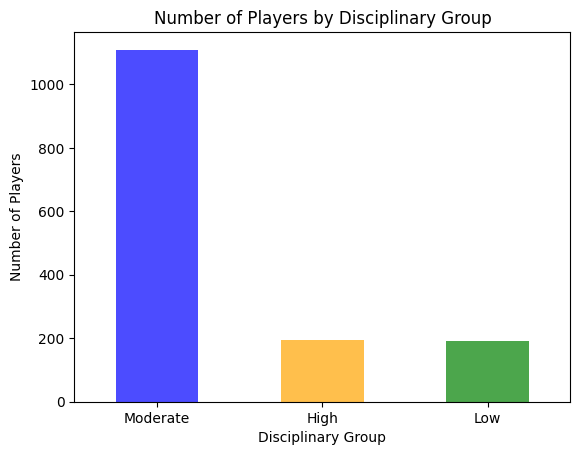

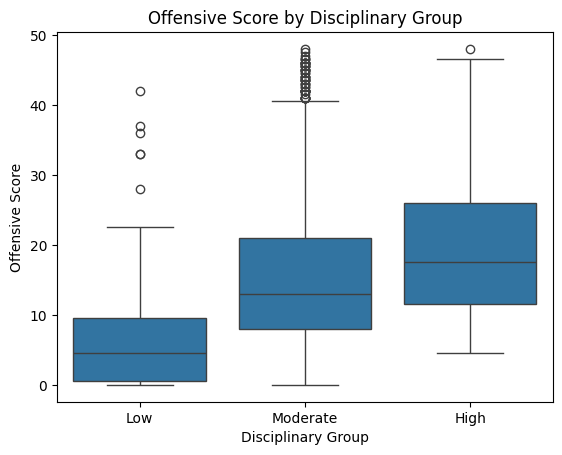

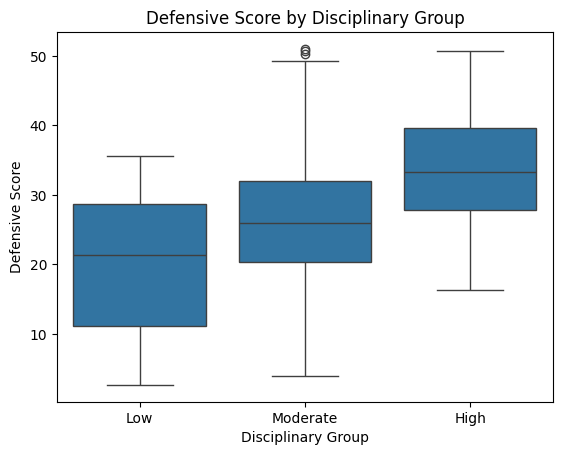

In [47]:
# Remove Outliers
def remove_outliers(group):
    # Calculate the IQR for offensive_score and defensive_score
    Q1_offensive = group['offensive_score'].quantile(0.25)
    Q3_offensive = group['offensive_score'].quantile(0.75)
    IQR_offensive = Q3_offensive - Q1_offensive
    lower_bound_offensive = Q1_offensive - 1.5 * IQR_offensive
    upper_bound_offensive = Q3_offensive + 1.5 * IQR_offensive
    
    Q1_defensive = group['defensive_score'].quantile(0.25)
    Q3_defensive = group['defensive_score'].quantile(0.75)
    IQR_defensive = Q3_defensive - Q1_defensive
    lower_bound_defensive = Q1_defensive - 1.5 * IQR_defensive
    upper_bound_defensive = Q3_defensive + 1.5 * IQR_defensive
    
    # Filter out the outliers within each group
    filtered_group = group[
        (group['offensive_score'] >= lower_bound_offensive) & 
        (group['offensive_score'] <= upper_bound_offensive) & 
        (group['defensive_score'] >= lower_bound_defensive) & 
        (group['defensive_score'] <= upper_bound_defensive)
    ]
    return filtered_group

df_explore = pd.DataFrame()
attributes = ['name','total_yellow','total_red','total_goals','total_assists','total_cs','tackles','interception']
for attribute in attributes:
    df_explore[attribute] = df[attribute]
for index, row in df_explore.iterrows():
    # Calculate scores for the current row
    disciplinary_score = (row['total_yellow'] + 2 * row['total_red']) / 2
    offensive_score = (row['total_goals'] + row['total_assists']) / 2
    defensive_score = (row['tackles'] + row['interception'] + row['total_cs']) / 3
    
    # Assign values to the respective row using the index
    df_explore.at[index, 'disciplinary_score'] = disciplinary_score
    df_explore.at[index, 'offensive_score'] = offensive_score
    df_explore.at[index, 'defensive_score'] = defensive_score

# Label the players group by disciplinary score
mean_score = df_explore['disciplinary_score'].mean()
std_score = df_explore['disciplinary_score'].std()

# Define conditions for grouping
conditions = [
    df_explore['disciplinary_score'] < (mean_score - std_score),  # Low
    (df_explore['disciplinary_score'] >= (mean_score - std_score)) & 
    (df_explore['disciplinary_score'] <= (mean_score + std_score)),  # Moderate
    df_explore['disciplinary_score'] > (mean_score + std_score)  # High
]

# Define group labels
labels = ['Low', 'Moderate', 'High']

# Assign groups to a new column
df_explore['disciplinary_group'] = pd.cut(
    df_explore['disciplinary_score'], 
    bins=[-float('inf'), mean_score - std_score, mean_score + std_score, float('inf')],
    labels=labels
)

df_explore = remove_outliers(df_explore)


group_counts = df_explore['disciplinary_group'].value_counts()
# Bar chart of group counts
group_counts.plot(kind='bar', color=['blue', 'orange', 'green'], alpha=0.7)
plt.title('Number of Players by Disciplinary Group')
plt.xlabel('Disciplinary Group')
plt.ylabel('Number of Players')
plt.xticks(rotation=0)
plt.show()

# Offensive Score Boxplot (for all groups after outlier removal)
sns.boxplot(x='disciplinary_group', y='offensive_score', data=df_explore)
plt.title('Offensive Score by Disciplinary Group')
plt.xlabel('Disciplinary Group')
plt.ylabel('Offensive Score')
plt.show()

# Defensive Score Boxplot (for all groups after outlier removal)
sns.boxplot(x='disciplinary_group', y='defensive_score', data=df_explore)
plt.title('Defensive Score by Disciplinary Group')
plt.xlabel('Disciplinary Group')
plt.ylabel('Defensive Score')
plt.show()

In [48]:
correlation_offensive = df_explore['disciplinary_score'].corr(df_explore['offensive_score'])
correlation_defensive = df_explore['disciplinary_score'].corr(df_explore['defensive_score'])
# Output results
print(f"Correlation between Disciplinary Score and Offensive Score: {correlation_offensive:.2f}")
print(f"Correlation between Disciplinary Score and Defensive Score: {correlation_defensive:.2f}")

Correlation between Disciplinary Score and Offensive Score: 0.33
Correlation between Disciplinary Score and Defensive Score: 0.44


### Results Interpretation:
- 0.33 for the correlation between disciplinary score and offensive score, which suggests a moderate positive correlation. This means that as the disciplinary score increases, the offensive score tends to increase as well, but the relationship is not perfectly strong.
- 0.44 for the correlation between disciplinary score and defensive score, which indicates a slightly weaker positive correlation, meaning that as the disciplinary score increases, the defensive score also tends to increase, but again, it's a moderate relationship.

### Residual Distribution

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21248\4148030454.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = df_explore.groupby('disciplinary_group')['offensive_score'].transform('mean')


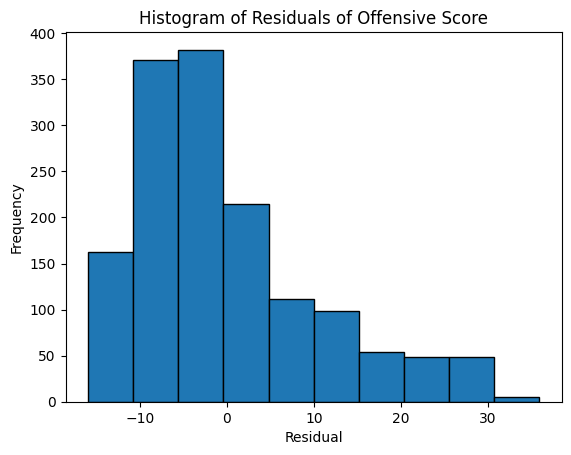

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21248\4148030454.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = df_explore.groupby('disciplinary_group')['defensive_score'].transform('mean')


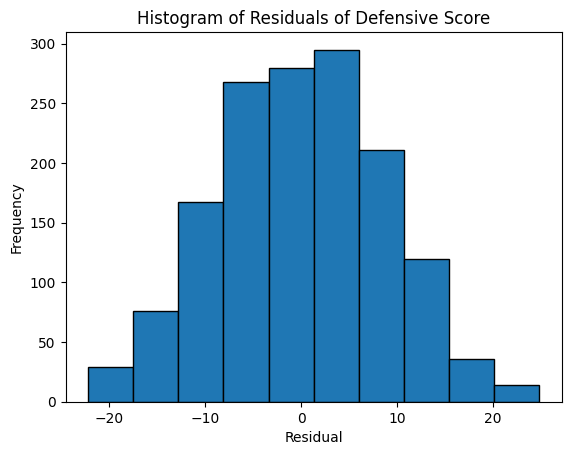

In [49]:
# Calculate group means
group_means = df_explore.groupby('disciplinary_group')['offensive_score'].transform('mean')

# Add the group means to the DataFrame
df_explore['Offensive Group Mean'] = group_means
df_explore['Residual'] = df_explore['offensive_score'] - df_explore['Offensive Group Mean']

# Plot histogram of residuals
plt.hist(df_explore['Residual'], bins=10, edgecolor='k')
plt.title('Histogram of Residuals of Offensive Score')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Calculate group means
group_means = df_explore.groupby('disciplinary_group')['defensive_score'].transform('mean')

# Add the group means to the DataFrame
df_explore['Defensive Group Mean'] = group_means
df_explore['Residual'] = df_explore['defensive_score'] - df_explore['Defensive Group Mean']

# Plot histogram of residuals
plt.hist(df_explore['Residual'], bins=10, edgecolor='k')
plt.title('Histogram of Residuals of Defensive Score')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

### Anova Test to determine if there are any statistically significant differences among the groups

In [50]:
offensive_groups = [group['offensive_score'].values for name, group in df_explore.groupby('disciplinary_group', observed=False)]
defensive_groups = [group['defensive_score'].values for name, group in df_explore.groupby('disciplinary_group', observed=False)]

# Offensive Score ANOVA
offensive_anova = stats.f_oneway(*offensive_groups)
print("Offensive Score ANOVA Results:")
print(f"F-statistic: {offensive_anova.statistic:.4f}")
print(f"P-value: {offensive_anova.pvalue:.4f}")

# Check if the p-value is significant
if offensive_anova.pvalue < 0.05:
    print("There are significant differences among the groups.")
else:
    print("There are no significant differences among the groups.")
print("\n")

# Defensive Score ANOVA
defensive_anova = stats.f_oneway(*defensive_groups)
print("Defensive Score ANOVA Results:")
print(f"F-statistic: {defensive_anova.statistic:.4f}")
print(f"P-value: {defensive_anova.pvalue:.4f}")

# Check if the p-value is significant
if defensive_anova.pvalue < 0.05:
    print("There are significant differences among the groups.")
else:
    print("There are no significant differences among the groups.")


Offensive Score ANOVA Results:
F-statistic: 98.6908
P-value: 0.0000
There are significant differences among the groups.


Defensive Score ANOVA Results:
F-statistic: 124.7348
P-value: 0.0000
There are significant differences among the groups.


### Result: The null hypothesis states that there are significant differences between the means of the groups
- A p-value this smaller than your typical significants (ie. 0.05) means the observed differences between the groups are extremely unlikely to have occurred by chance
- We can confidently reject the null hypothesis and conclude that the means of the groups are significantly different.
###  Post-hoc test
We should use a test like Tukey's Honest Significant Difference (HSD) to determine which specific groups differ significantly. Disciplinary Score Groups (Low, Moderate, High) have a statistically significant effect on the variable being analyzed (e.g., offensive_score or defensive_score).

In [51]:
# Offensive Score Post-Hoc Test
tukey_offensive = pairwise_tukeyhsd(df_explore['offensive_score'], df_explore['disciplinary_group'])
# Displaying Offensive Score Results dynamically
print("Offensive Score Tukey's HSD Results:")
for comparison in tukey_offensive.summary().data[1:]:
    group1, group2 = comparison[0], comparison[1]
    meandiff = comparison[2]
    p_adj = comparison[4]
    print(f"{group1} vs {group2}: The mean difference between {group1} and {group2} groups is {meandiff:.4f}, "
          f"which is {'statistically significant' if p_adj < 0.05 else 'not statistically significant'} "
          f"with a p-value of {p_adj:.4f}.")
print("\n")


# Defensive Score Post-Hoc Test
tukey_defensive = pairwise_tukeyhsd(df_explore['defensive_score'], df_explore['disciplinary_group'])
# Displaying Defensive Score Results dynamically
print("Defensive Score Tukey's HSD Results:")
for comparison in tukey_defensive.summary().data[1:]:
    group1, group2 = comparison[0], comparison[1]
    meandiff = comparison[2]
    p_adj = comparison[4]
    print(f"{group1} vs {group2}: The mean difference between {group1} and {group2} groups is {meandiff:.4f}, "
          f"which is {'statistically significant' if p_adj < 0.05 else 'not statistically significant'} "
          f"with a p-value of {p_adj:.4f}.")

Offensive Score Tukey's HSD Results:
High vs Low: The mean difference between High and Low groups is -14.2321, which is statistically significant with a p-value of -16.7318.
High vs Moderate: The mean difference between High and Moderate groups is -4.3665, which is statistically significant with a p-value of -6.2757.
Low vs Moderate: The mean difference between Low and Moderate groups is 9.8656, which is not statistically significant with a p-value of 7.9438.


Defensive Score Tukey's HSD Results:
High vs Low: The mean difference between High and Low groups is -13.8557, which is statistically significant with a p-value of -15.9220.
High vs Moderate: The mean difference between High and Moderate groups is -7.5954, which is statistically significant with a p-value of -9.1736.
Low vs Moderate: The mean difference between Low and Moderate groups is 6.2604, which is not statistically significant with a p-value of 4.6717.


### Offensive Score Tukey's HSD Conclusions
- Players in the Low disciplinary group outperform those in both the Moderate and High groups in terms of offensive performance.
- Players in the High disciplinary group have the poorest offensive performance.
- Increased disciplinary actions may negatively impact offensive contributions.

### Defensive Score Tukey's HSD Conclusions
- Players in the Low disciplinary group outperform those in both the Moderate and High groups in terms of defensive contributions.
- Players in the High disciplinary group also have the lowest defensive performance.
- Higher disciplinary actions may negatively correlate with defensive contributions.


## Overall Conclusion
- Offensive and Defensive Performance Declines with Disciplinary Actions:

Players in the High disciplinary group perform poorly both offensively and defensively compared to those in the Low and Moderate groups.
- Low Disciplinary Actions Indicate Better Performance:

Players in the Low disciplinary group show significantly higher offensive and defensive scores.
- Encourage teams to focus on discipline during training to enhance overall player performance.

## What combination of performance metrics and personal attributes most consistently correlates with a player’s likelihood of winning titles? 
### 

### Select the attributes

In [850]:
attributes = [
    'age', 'height', 'weight', 'total_matches', 
    'total_goals', 'total_assists', 'total_cs', 'total_goals_conceded', 
    'total_yellow', 'total_red', 'shot_accuracy', 'pass_completion_rate', 
    'cross_completion_rate', 'dribble_success_rate', 'tackles', 
    'interception', 'market_value', 'titles'
]
df_explore = df[attributes].copy()

### Examine the distribution of titles 

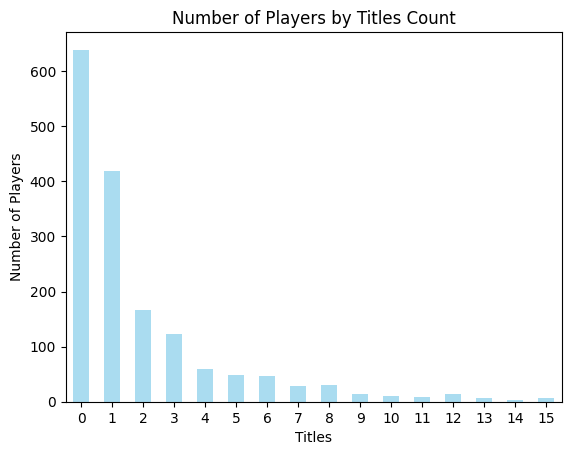

In [851]:
# Calculate the counts of each unique value in the 'titles' column
title_counts = df_explore['titles'].value_counts().sort_index()  # Sort the values for better clarity

title_counts.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Number of Players by Titles Count')
plt.xlabel('Titles')
plt.ylabel('Number of Players')
plt.xticks(rotation=0)
plt.show()

### Split the Data into Groups

In this step, we group the players based on the number of titles they have won. The goal is to categorize the players into three distinct groups:

1. **No Titles**: Players who have not won any titles (i.e., `titles == 0`).
2. **Avg Titles**: Players who have won a number of titles up to the average title count (i.e., `titles > 0` and `titles <= mean`).
3. **Above Avg Titles**: Players who have won more than the average number of titles (i.e., `titles > mean`).

3.078252032520325


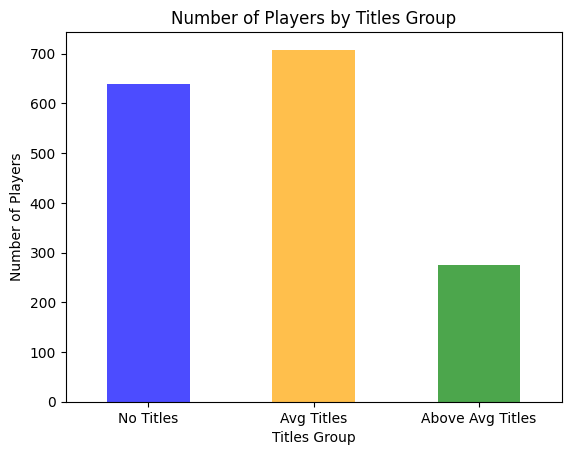

In [852]:
# Calculate the mean of titles (greater than 0)
mean_score = df_explore[df_explore['titles'] > 0]['titles'].mean()
print(mean_score)

# Define conditions for grouping
conditions = [
    df_explore['titles'] == 0,                           # No titles
    (df_explore['titles'] > 0) & (df_explore['titles'] <= mean_score),  # Avg titles
    df_explore['titles'] > mean_score                   # More than avg titles
]

labels = ['No Titles', 'Avg Titles', 'Above Avg Titles']

# Assign groups to a new column
df_explore['titles_group'] = pd.cut(
    df_explore['titles'], 
    bins=[-float('inf'), 0, mean_score, float('inf')],
    labels=labels,
    ordered=False
)

df_explore['titles_group'] = pd.Categorical(df_explore['titles_group'], categories=['No Titles', 'Avg Titles', 'Above Avg Titles'], ordered=True)

# Calculate the counts of each group in the 'titles_group' column
group_counts = df_explore['titles_group'].value_counts()

# Re-order the group counts to follow the intended custom order
group_counts = group_counts[['No Titles', 'Avg Titles', 'Above Avg Titles']]

# Create a bar chart with the correct order of groups
group_counts.plot(kind='bar', color=['blue', 'orange', 'green'], alpha=0.7)
plt.title('Number of Players by Titles Group')
plt.xlabel('Titles Group')
plt.ylabel('Number of Players')
plt.xticks(rotation=0)
plt.show()

### Examine the means across the titles group

In [853]:
df_explore['ball_skill'] = (df_explore['pass_completion_rate'] + df_explore['cross_completion_rate'] + df_explore['shot_accuracy'] + df_explore['dribble_success_rate']) / 4
df_explore['disciplinary_score'] = (df_explore['total_yellow'] + df_explore['total_red']*2) / 2
df_explore['defense_skill'] = (df_explore['interception'] + df_explore['tackles']) / 2
# Define the list of numeric attributes (excluding categorical columns)
numeric_attributes = [
    'age', 'height', 'weight', 'total_matches', 'total_goals', 'total_assists',
    'total_cs', 'total_goals_conceded', 'ball_skill','disciplinary_score','defense_skill', 'market_value'
]
# Group by the titles group and calculate the mean for each feature
mean_values_by_titles_group = df_explore.groupby('titles_group',observed=False)[numeric_attributes].mean()
display(mean_values_by_titles_group)

,age,height,weight,total_matches,total_goals,total_assists,total_cs,total_goals_conceded,ball_skill,disciplinary_score,defense_skill,market_value
titles_group,,,,,,,,,,,,
No Titles,24.395931,182.477308,74.297340,164.300469,16.356808,12.291080,63.574335,217.583725,45.614448,13.454617,5.776995,7.705556
Avg Titles,25.860169,182.855932,75.101695,220.553672,20.365819,16.288136,70.495763,236.042373,46.610413,18.668079,6.197740,9.191702
Above Avg Titles,27.597826,182.304348,75.246377,301.554348,27.851449,21.666667,79.521739,255.242754,46.823542,24.211957,6.364130,12.961232


### Visualize different of mean stats by groups

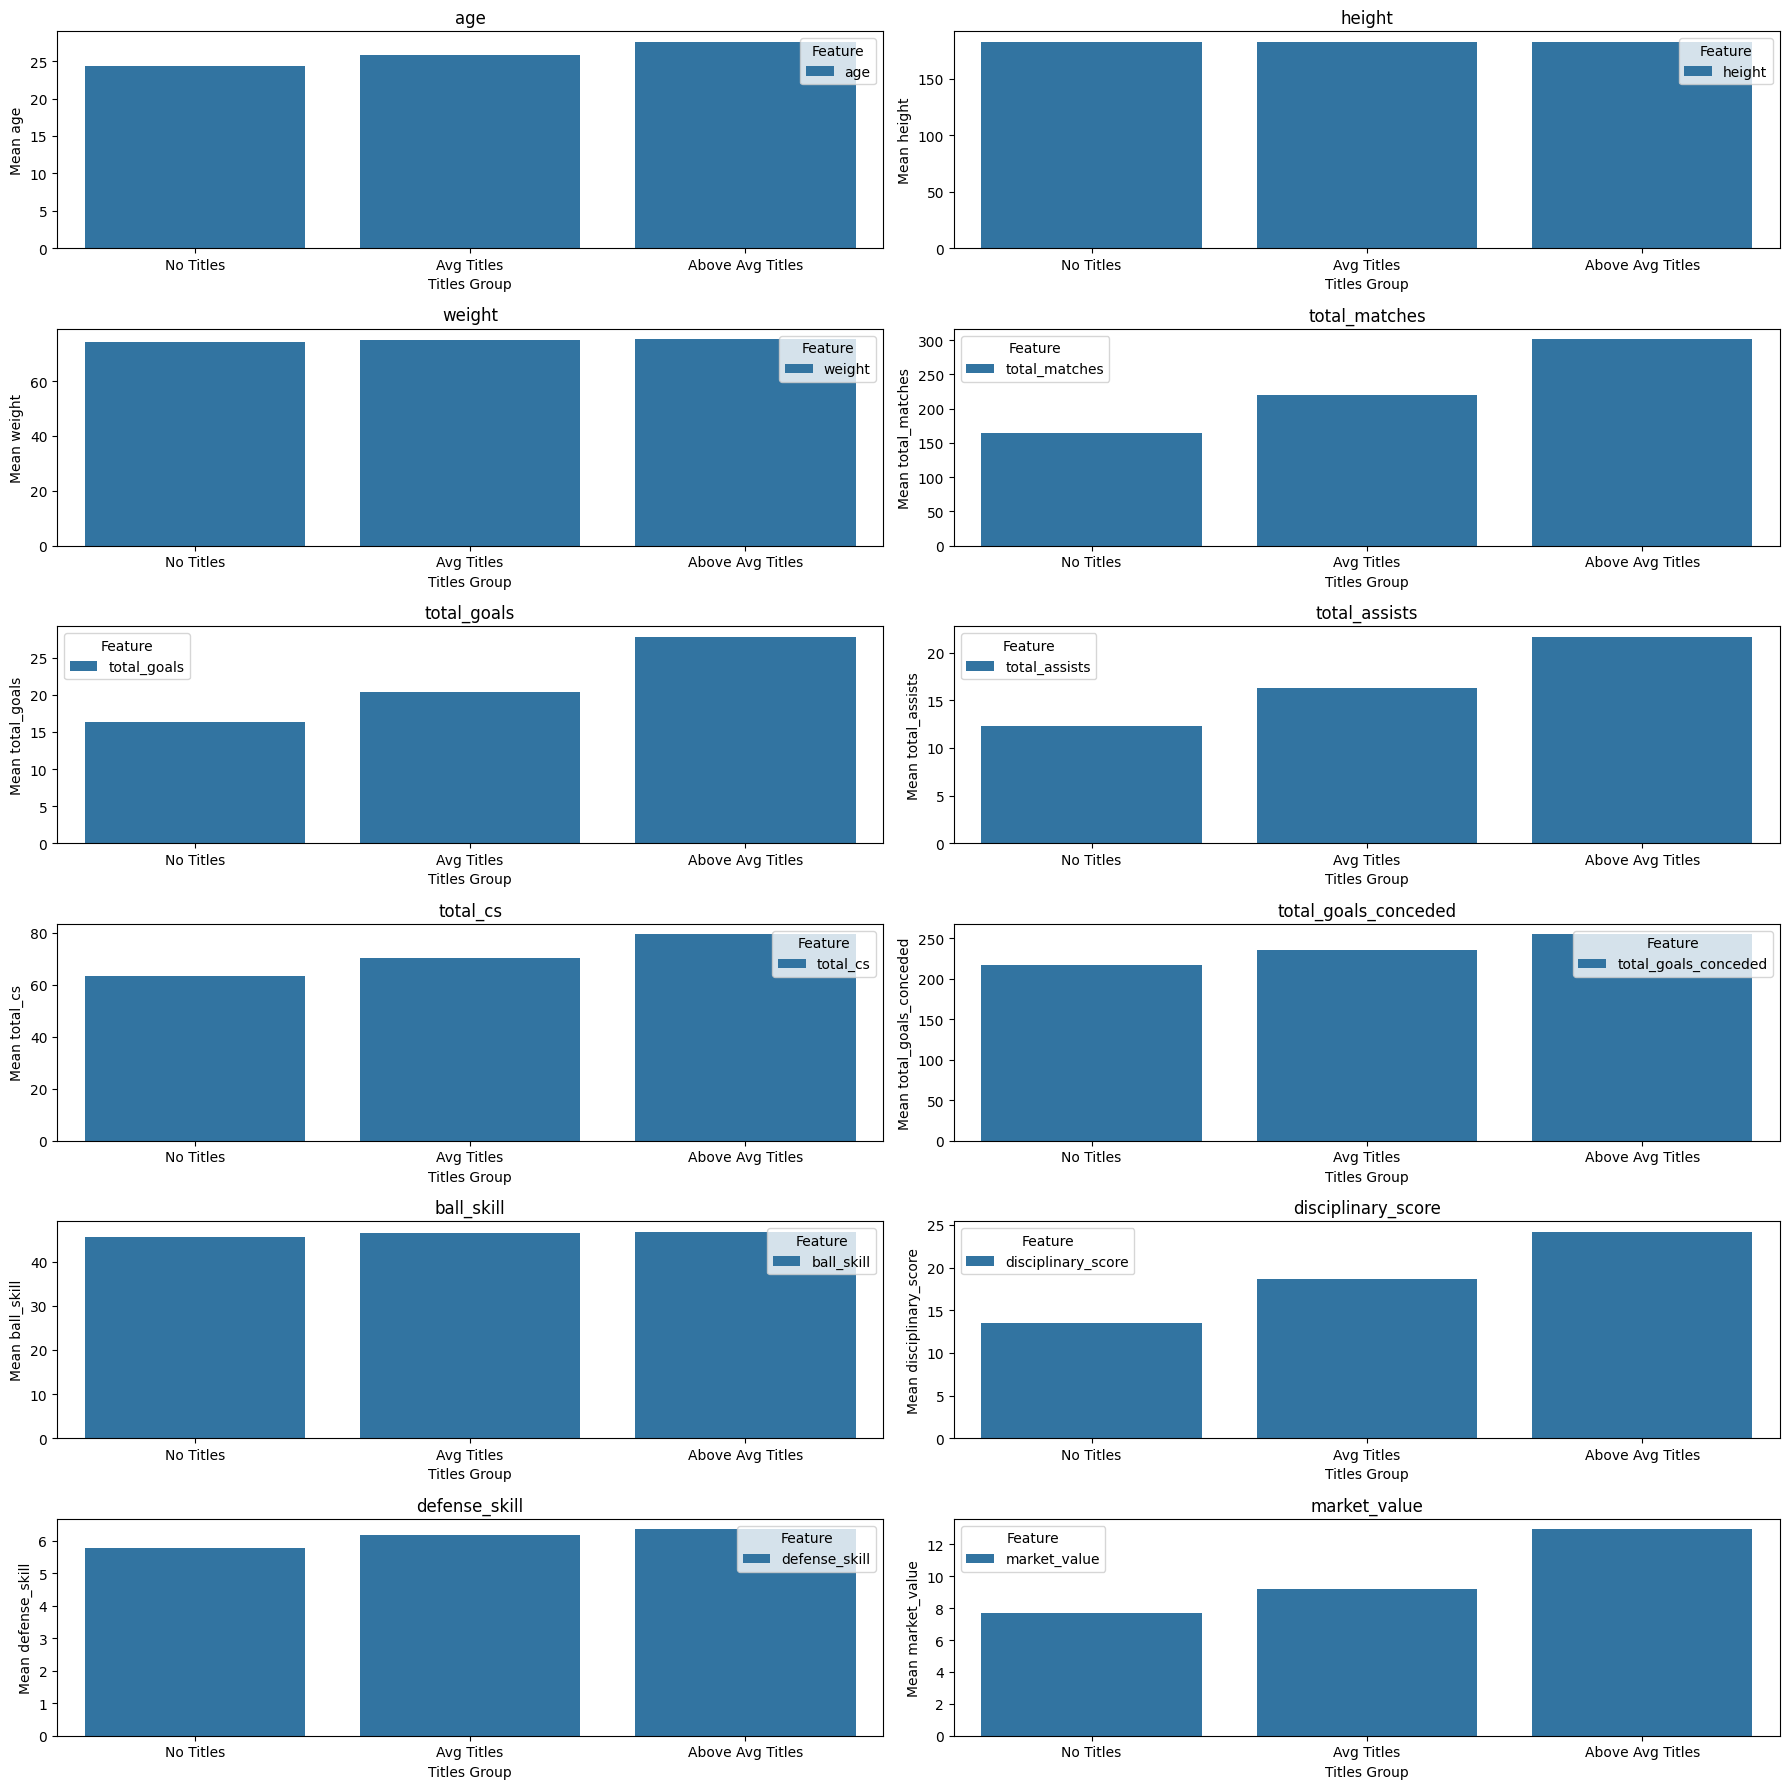

In [854]:
# Set up the plot: Calculate rows and columns dynamically based on the number of features
num_features = len(numeric_attributes)
ncols = 2  # 2 columns for the grid
nrows = (num_features + 1) // ncols  # Round up to ensure enough rows

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, nrows * 3))

axes = axes.flatten()

mean_values_by_titles_group_melted = mean_values_by_titles_group.reset_index().melt(id_vars='titles_group', var_name='Feature', value_name='Mean Value')

bar_width = 0.2 
for i, feature in enumerate(numeric_attributes):
    ax = axes[i]
    
    feature_data = mean_values_by_titles_group_melted[mean_values_by_titles_group_melted['Feature'] == feature]
    
    sns.barplot(x='titles_group', y='Mean Value', hue='Feature', data=feature_data, ax=ax, dodge=True)
    
    ax.set_title(f'{feature}')
    ax.set_xlabel('Titles Group')
    ax.set_ylabel(f'Mean {feature}')
    
    ax.set_xticks(np.arange(len(mean_values_by_titles_group.index)))
    ax.set_xticklabels(mean_values_by_titles_group.index)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Conclusion
### - The combination of metrics that might correlates the most with titles won are `total_matches`, `total_goals`, `total_assists`, `disciplinary_score` and `market_value` based on the significant different across the groups.
